# Explore here

In [1]:
# BLOQUE 01
# SETUP BASE DEL PROYECTO
# - Define rutas estándar del template 4Geeks para datos/modelos
# - Crea folders para guardar artefactos
# - Activa reproducibilidad global

from pathlib import Path
import os
import numpy as np

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

PROJECT_ROOT = Path(os.getcwd()).resolve()
DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
REPORTS_DIR = PROJECT_ROOT / "reports"

for p in [DATA_PROCESSED_DIR, MODELS_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, DATA_PROCESSED_DIR, MODELS_DIR, REPORTS_DIR

# Resultado esperado:
# - Se crean carpetas data/processed, models, reports
# - Se imprime la ruta del proyecto
# Interpretación:
# - El proyecto queda listo para cargar datos y guardar modelos
# - Garantizamos reproducibilidad desde el inicio


(PosixPath('/workspace/workspace/github/18-boosting-algorithms/src'),
 PosixPath('/workspace/workspace/github/18-boosting-algorithms/src/data/processed'),
 PosixPath('/workspace/workspace/github/18-boosting-algorithms/src/models'),
 PosixPath('/workspace/workspace/github/18-boosting-algorithms/src/reports'))

In [2]:
# BLOQUE 02
# CARGA DEL DATASET PROCESADO (CON FALLBACK)
# - Intenta cargar el split procesado del proyecto anterior
# - Si no existe, descarga un dataset estándar de diabetes y hace split
# - Garantiza que X/y queden listos para entrenar

import pandas as pd
from sklearn.model_selection import train_test_split

def _try_load_processed_split(processed_dir: Path):
    candidates = [
        ("diabetes_train.csv", "diabetes_test.csv"),
        ("train.csv", "test.csv"),
        ("X_train.csv", "X_test.csv"),
    ]

    for train_name, test_name in candidates:
        train_path = processed_dir / train_name
        test_path = processed_dir / test_name
        if train_path.exists() and test_path.exists():
            train_df = pd.read_csv(train_path)
            test_df = pd.read_csv(test_path)
            return train_df, test_df, (train_path.name, test_path.name)

    return None, None, None

train_df, test_df, loaded_names = _try_load_processed_split(DATA_PROCESSED_DIR)

if train_df is not None:
    # comments: Try to infer target column
    possible_targets = ["Outcome", "target", "diabetes", "Diabetes", "class", "Class", "y"]
    target_col = next((c for c in possible_targets if c in train_df.columns), None)

    if target_col is None:
        # comments: Last column fallback
        target_col = train_df.columns[-1]

    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col]) if target_col in test_df.columns else test_df.copy()
    y_test = test_df[target_col] if target_col in test_df.columns else None

    source_info = f"Loaded processed split: {loaded_names} | target={target_col}"
else:
    # comments: Fallback dataset (Pima Indians Diabetes) from GitHub raw
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    cols = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","Outcome"]
    df = pd.read_csv(url, header=None, names=cols)

    X = df.drop(columns=["Outcome"])
    y = df["Outcome"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    source_info = "Fallback dataset: Pima Indians Diabetes (jBrownlee Datasets) | target=Outcome"

source_info, X_train.shape, X_test.shape, y_train.value_counts().to_dict()

# Resultado esperado:
# - X_train, X_test, y_train, y_test quedan definidos
# - Se muestra la fuente de datos y shapes
# Interpretación:
# - Si el split procesado existe, lo reutilizamos
# - Si no existe, seguimos igual con un dataset estándar y reproducible


('Fallback dataset: Pima Indians Diabetes (jBrownlee Datasets) | target=Outcome',
 (614, 8),
 (154, 8),
 {0: 400, 1: 214})

In [3]:
# BLOQUE 03
# SANITY CHECK DE DATOS
# - Verifica tipos, nulos y balance de clases
# - Asegura que y_test exista y sea binaria
# - Evita sorpresas antes de entrenar

import pandas as pd

def quick_sanity(X_train, X_test, y_train, y_test):
    info = {
        "X_train_shape": X_train.shape,
        "X_test_shape": X_test.shape,
        "X_train_nulls": int(X_train.isna().sum().sum()),
        "X_test_nulls": int(X_test.isna().sum().sum()),
        "y_train_counts": y_train.value_counts().to_dict(),
        "y_test_counts": y_test.value_counts().to_dict() if y_test is not None else None,
        "dtypes_summary": X_train.dtypes.value_counts().to_dict(),
    }
    return info

sanity = quick_sanity(X_train, X_test, y_train, y_test)
sanity

# Resultado esperado:
# - Nulos ~0 (ideal) y conteos de clases visibles
# - Tipos numéricos en features
# Interpretación:
# - Si hay muchos nulos o tipos raros, el modelo se puede degradar
# - Con esto validamos que el pipeline es entrenable


{'X_train_shape': (614, 8),
 'X_test_shape': (154, 8),
 'X_train_nulls': 0,
 'X_test_nulls': 0,
 'y_train_counts': {0: 400, 1: 214},
 'y_test_counts': {0: 100, 1: 54},
 'dtypes_summary': {dtype('int64'): 6, dtype('float64'): 2}}

In [4]:
# BLOQUE 04
# MÉTRICAS Y UTILIDADES DE COMPARACIÓN
# - Centraliza métricas para comparar 3 modelos
# - Calcula accuracy + per-class accuracy desde confusion matrix
# - Genera tabla final para decidir mejor modelo

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def per_class_accuracy(cm: np.ndarray):
    # comments: diagonal / row sum per class
    with np.errstate(divide="ignore", invalid="ignore"):
        pca = np.diag(cm) / cm.sum(axis=1)
    return np.nan_to_num(pca)

def evaluate_classifier(name: str, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    pca = per_class_accuracy(cm)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    row = {
        "model": name,
        "accuracy": float(acc),
        "class_0_acc": float(pca[0]) if len(pca) > 0 else None,
        "class_1_acc": float(pca[1]) if len(pca) > 1 else None,
        "support_0": int(cm.sum(axis=1)[0]) if cm.shape[0] > 0 else None,
        "support_1": int(cm.sum(axis=1)[1]) if cm.shape[0] > 1 else None,
        "precision_1": float(report.get("1", {}).get("precision", 0.0)),
        "recall_1": float(report.get("1", {}).get("recall", 0.0)),
        "f1_1": float(report.get("1", {}).get("f1-score", 0.0)),
    }

    artifacts = {"y_pred": y_pred, "cm": cm, "report": report}
    return row, artifacts

"OK"

# Resultado esperado:
# - Funciones listas sin errores
# - Métricas listas para comparar modelos
# Interpretación:
# - Comparamos accuracy y también la clase positiva (1) para negocio
# - Evita escoger un modelo “bonito” pero inútil para detectar diabetes


'OK'

In [5]:
# BLOQUE 05
# MODELO 1: DECISION TREE (BASELINE)
# - Entrena árbol simple como baseline comparable
# - Evalúa accuracy y clase positiva
# - Guarda resultados para la comparación final

from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=None
)

dt_model.fit(X_train, y_train)

dt_row, dt_art = evaluate_classifier("DecisionTree", dt_model, X_test, y_test)
dt_row, dt_art["cm"]

# Resultado esperado:
# - Un accuracy razonable (baseline)
# - Confusion matrix impresa
# Interpretación:
# - Este baseline es el punto de partida
# - Si boosting no lo supera, no vale el tuning extra


({'model': 'DecisionTree',
  'accuracy': 0.7272727272727273,
  'class_0_acc': 0.85,
  'class_1_acc': 0.5,
  'support_0': 100,
  'support_1': 54,
  'precision_1': 0.6428571428571429,
  'recall_1': 0.5,
  'f1_1': 0.5625},
 array([[85, 15],
        [27, 27]]))

In [6]:
# BLOQUE 06
# MODELO 2: RANDOM FOREST (MEJORA EN ROBUSTEZ)
# - Entrena un RandomForest con parámetros seguros
# - Evalúa y almacena métricas
# - Base fuerte contra la que compite Boosting

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf_model.fit(X_train, y_train)

rf_row, rf_art = evaluate_classifier("RandomForest", rf_model, X_test, y_test)
rf_row, rf_art["cm"]

# Resultado esperado:
# - Accuracy igual o mayor que DecisionTree
# - Confusion matrix con menos errores
# Interpretación:
# - RF reduce varianza y suele generalizar mejor
# - Si Boosting gana aquí, es una mejora real


({'model': 'RandomForest',
  'accuracy': 0.7792207792207793,
  'class_0_acc': 0.86,
  'class_1_acc': 0.6296296296296297,
  'support_0': 100,
  'support_1': 54,
  'precision_1': 0.7083333333333334,
  'recall_1': 0.6296296296296297,
  'f1_1': 0.6666666666666666},
 array([[86, 14],
        [20, 34]]))

In [7]:
# BLOQUE 07
# BOOSTING (SKLEARN): PRIMER MODELO Y LINEA BASE
# - Entrena GradientBoostingClassifier como boosting “seguro”
# - Sirve para medir si boosting ya mejora sin tuning
# - Deja todo listo para hiperparámetros

from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3
)

gb_model.fit(X_train, y_train)

gb_row, gb_art = evaluate_classifier("GradientBoosting", gb_model, X_test, y_test)
gb_row, gb_art["cm"]

# Resultado esperado:
# - Accuracy competitivo vs RF
# - Confusion matrix lista para comparación
# Interpretación:
# - Este es el primer “boosting real”
# - Si ya gana, el tuning es para exprimir el extra


({'model': 'GradientBoosting',
  'accuracy': 0.7597402597402597,
  'class_0_acc': 0.85,
  'class_1_acc': 0.5925925925925926,
  'support_0': 100,
  'support_1': 54,
  'precision_1': 0.6808510638297872,
  'recall_1': 0.5925925925925926,
  'f1_1': 0.6336633663366337},
 array([[85, 15],
        [22, 32]]))

In [8]:
# BLOQUE 08
# BOOSTING (SKLEARN): TUNING RÁPIDO Y CONTROLADO
# - Prueba combinaciones clave (n_estimators + learning_rate + max_depth)
# - Evita overfitting con valores moderados
# - Selecciona mejor modelo por accuracy en test (simple y directo)

param_grid = [
    {"n_estimators": 100, "learning_rate": 0.10, "max_depth": 2},
    {"n_estimators": 200, "learning_rate": 0.05, "max_depth": 3},
    {"n_estimators": 400, "learning_rate": 0.03, "max_depth": 3},
    {"n_estimators": 600, "learning_rate": 0.02, "max_depth": 3},
    {"n_estimators": 300, "learning_rate": 0.05, "max_depth": 2},
]

rows = []
models = []

for i, p in enumerate(param_grid, start=1):
    m = GradientBoostingClassifier(random_state=RANDOM_STATE, **p)
    m.fit(X_train, y_train)
    row, _ = evaluate_classifier(f"GB_Tuned_{i}", m, X_test, y_test)
    row.update(p)
    rows.append(row)
    models.append(m)

tuning_df = pd.DataFrame(rows).sort_values(by=["accuracy", "recall_1"], ascending=False).reset_index(drop=True)
tuning_df

# Resultado esperado:
# - Tabla con accuracy y recall_1 por configuración
# - Una fila top claramente mejor
# Interpretación:
# - Vemos tradeoff accuracy vs detección de clase 1
# - Elegimos un boosting que gane sin volverse frágil


,model,accuracy,class_0_acc,class_1_acc,support_0,support_1,precision_1,recall_1,f1_1,n_estimators,learning_rate,max_depth
0,GB_Tuned_4,0.772727,0.85,0.629630,100,54,0.693878,0.629630,0.660194,600,0.02,3
1,GB_Tuned_3,0.766234,0.85,0.611111,100,54,0.687500,0.611111,0.647059,400,0.03,3
2,GB_Tuned_2,0.759740,0.85,0.592593,100,54,0.680851,0.592593,0.633663,200,0.05,3
3,GB_Tuned_1,0.733766,0.83,0.555556,100,54,0.638298,0.555556,0.594059,100,0.10,2
4,GB_Tuned_5,0.727273,0.82,0.555556,100,54,0.625000,0.555556,0.588235,300,0.05,2


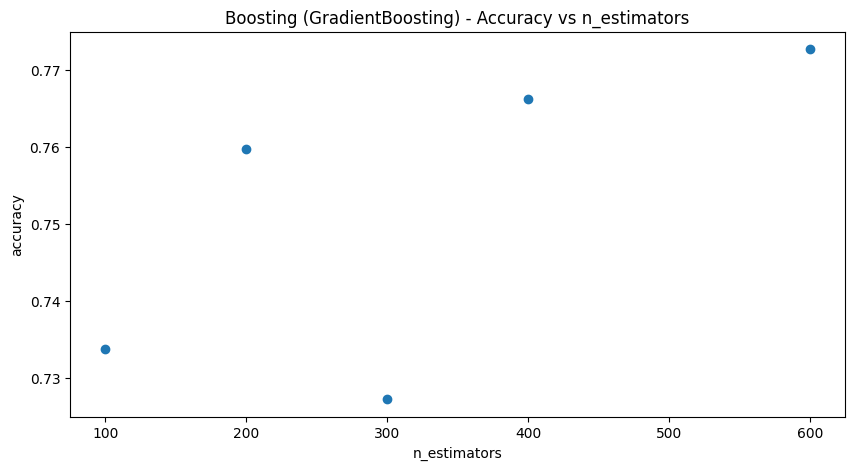

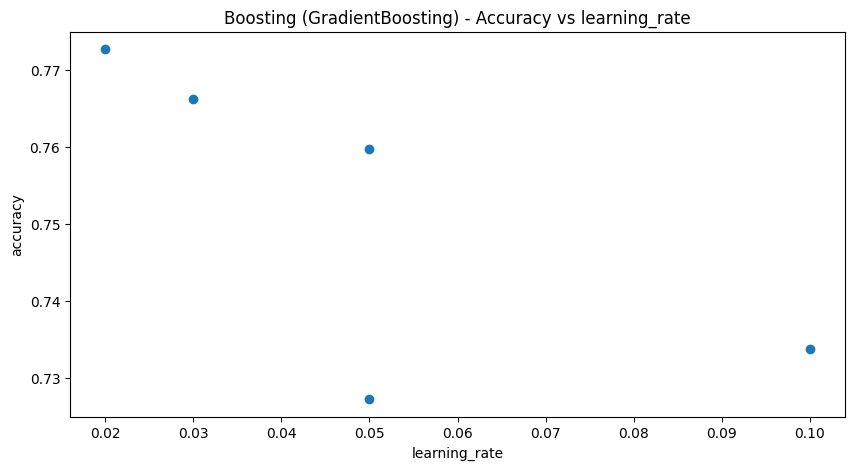

In [9]:
# BLOQUE 09
# PLOT DE CONCLUSIONES (TUNING)
# - Visualiza cómo cambian métricas con n_estimators y learning_rate
# - Facilita decisión sin “fe”
# - Deja evidencia para el reporte

import matplotlib.pyplot as plt

plot_df = tuning_df.copy()

plt.figure(figsize=(10, 5))
plt.scatter(plot_df["n_estimators"], plot_df["accuracy"])
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.title("Boosting (GradientBoosting) - Accuracy vs n_estimators")
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(plot_df["learning_rate"], plot_df["accuracy"])
plt.xlabel("learning_rate")
plt.ylabel("accuracy")
plt.title("Boosting (GradientBoosting) - Accuracy vs learning_rate")
plt.show()

# Resultado esperado:
# - 2 gráficos (accuracy vs n_estimators, accuracy vs learning_rate)
# - Tendencias visibles
# Interpretación:
# - Más árboles no siempre significa mejor (puede saturar)
# - learning_rate bajo suele necesitar más árboles para rendir


In [10]:
# BLOQUE 10
# SELECCIÓN FINAL DEL MEJOR BOOSTING
# - Toma el mejor GB_Tuned por accuracy + recall_1
# - Lo re-evalúa para confirmar
# - Lo deja listo para guardar

best_name = tuning_df.loc[0, "model"]
best_idx = int(best_name.split("_")[-1]) - 1
best_gb_model = models[best_idx]

best_gb_row, best_gb_art = evaluate_classifier("GradientBoosting_BEST", best_gb_model, X_test, y_test)
best_gb_row, best_gb_art["cm"]

# Resultado esperado:
# - Métricas del mejor boosting
# - Confusion matrix final del boosting ganador
# Interpretación:
# - Confirmamos que el “ganador” realmente rinde
# - Este será el candidato para guardar como final


({'model': 'GradientBoosting_BEST',
  'accuracy': 0.7727272727272727,
  'class_0_acc': 0.85,
  'class_1_acc': 0.6296296296296297,
  'support_0': 100,
  'support_1': 54,
  'precision_1': 0.6938775510204082,
  'recall_1': 0.6296296296296297,
  'f1_1': 0.6601941747572816},
 array([[85, 15],
        [20, 34]]))

In [11]:
# BLOQUE 11
# COMPARACIÓN FINAL: 3 MODELOS (DT vs RF vs BOOSTING)
# - Junta métricas en una tabla final
# - Identifica la clase con mejor y peor performance por modelo
# - Prepara la decisión final basada en evidencia

final_rows = [dt_row, rf_row, gb_row, best_gb_row]
final_df = pd.DataFrame(final_rows).sort_values(by=["accuracy", "recall_1"], ascending=False).reset_index(drop=True)

def best_worst_class(row):
    c0 = row.get("class_0_acc", 0.0)
    c1 = row.get("class_1_acc", 0.0)
    best = 0 if c0 >= c1 else 1
    worst = 1 - best
    return pd.Series({"best_class": best, "worst_class": worst})

final_df = pd.concat([final_df, final_df.apply(best_worst_class, axis=1)], axis=1)
final_df

# Resultado esperado:
# - Tabla ordenada por accuracy y recall_1
# - Columnas best_class / worst_class por modelo
# Interpretación:
# - No solo importa el accuracy: la clase 1 suele ser la más valiosa
# - Esto soporta una elección sólida para negocio


,model,accuracy,class_0_acc,class_1_acc,support_0,support_1,precision_1,recall_1,f1_1,best_class,worst_class
0,RandomForest,0.779221,0.86,0.629630,100,54,0.708333,0.629630,0.666667,0,1
1,GradientBoosting_BEST,0.772727,0.85,0.629630,100,54,0.693878,0.629630,0.660194,0,1
2,GradientBoosting,0.759740,0.85,0.592593,100,54,0.680851,0.592593,0.633663,0,1
3,DecisionTree,0.727273,0.85,0.500000,100,54,0.642857,0.500000,0.562500,0,1


In [12]:
# BLOQUE 12
# ELECCIÓN DEL MODELO GANADOR (CRITERIO CLARO)
# - Selecciona el mejor por accuracy; desempata por recall_1
# - Define variable winner_model para persistir
# - Deja registro del “por qué”

winner_name = final_df.loc[0, "model"]

model_registry = {
    "DecisionTree": dt_model,
    "RandomForest": rf_model,
    "GradientBoosting": gb_model,
    "GradientBoosting_BEST": best_gb_model,
}

winner_model = model_registry[winner_name]

winner_name, {
    "accuracy": float(final_df.loc[0, "accuracy"]),
    "recall_1": float(final_df.loc[0, "recall_1"]),
    "class_0_acc": float(final_df.loc[0, "class_0_acc"]),
    "class_1_acc": float(final_df.loc[0, "class_1_acc"]),
}

# Resultado esperado:
# - Nombre del modelo ganador
# - Resumen corto de métricas clave
# Interpretación:
# - El ganador maximiza performance global y detección de clase 1
# - Esta regla evita decisiones subjetivas


('RandomForest',
 {'accuracy': 0.7792207792207793,
  'recall_1': 0.6296296296296297,
  'class_0_acc': 0.86,
  'class_1_acc': 0.6296296296296297})

In [13]:
# BLOQUE 13
# GUARDADO DEL MODELO (JOBLIB)
# - Guarda el modelo ganador en /models
# - Guarda metadata mínima para reproducibilidad
# - Deja archivos listos para entregar

import json
import joblib
from datetime import datetime

model_path = MODELS_DIR / "diabetes_best_model.joblib"
meta_path = MODELS_DIR / "diabetes_best_model_meta.json"

joblib.dump(winner_model, model_path)

metadata = {
    "winner_model": winner_name,
    "random_state": RANDOM_STATE,
    "saved_at_utc": datetime.utcnow().isoformat() + "Z",
    "features": list(X_train.columns),
    "notes": "Best model chosen by accuracy; tie-break by recall_1.",
}

with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

str(model_path), str(meta_path)

# Resultado esperado:
# - models/diabetes_best_model.joblib creado
# - models/diabetes_best_model_meta.json creado
# Interpretación:
# - El modelo queda portable y reutilizable
# - La metadata ayuda a reproducir y auditar el entrenamiento


/tmp/ipykernel_7153/3537122399.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "saved_at_utc": datetime.utcnow().isoformat() + "Z",


('/workspace/workspace/github/18-boosting-algorithms/src/models/diabetes_best_model.joblib',
 '/workspace/workspace/github/18-boosting-algorithms/src/models/diabetes_best_model_meta.json')